In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set(color_codes=True)

%matplotlib inline

In [68]:
# load training data text
train_file = pd.read_csv('train_data.csv',delimiter=',', header=0,
                        dtype={'name':str, 'lvl1':str, 'lvl2':str, 'lvl3':str, 'descrption':str, 'type':str})
train_file.columns = ['id', 'name','lvl1','lvl2','lvl3','descrption','price','type']
train_file.duplicated(subset=None, keep='first')
train_file.set_index('id', inplace = True)
train_file.head()

,name,lvl1,lvl2,lvl3,descrption,price,type
id,,,,,,,
1,Cuba Heartbreaker Eau De Parfum Spray 100ml/3.3oz,Health & Beauty,Bath & Body,Hand & Foot Care,Formulated with oil-free hydrating botanicals/...,128.00,international
2,32GB USB 3.0 Swivel Flash Drive Memory Stick S...,Computers & Laptops,Storage,Flash Drives,<ul> <li>Interface: USB 3.0</li> <li>Capacity:...,14.69,international
3,Eican ALP8L-01 Metal + PC Phone Cover Luxury A...,Mobiles & Tablets,Accessories,Phone Cases,<ul> <li>Aluminum Frame</li> <li>Built-in Stan...,14.10,international
4,IPAKY Hybrid Luxury Silicone Case Cover And Pl...,Mobiles & Tablets,Accessories,Phone Cases,<ul> <li>Ultal thin Slim Style + Full Protecti...,17.94,international
5,Phone case for iPhone 5/5s/SE You Can Be Sore ...,Mobiles & Tablets,Accessories,Phone Cases,<ul> <li>High Quality phone Case for iPhone 5/...,6.80,international


In [69]:
#clean up data for lvl1&2&3
train_file['lvl1'] = train_file['lvl1'].str.lower().replace('[^a-zA-Z]+',' ',regex=True)
#train_file['lvl1'] = train_file['lvl1'].str.strip()
train_file['lvl2'] = train_file['lvl2'].str.lower().replace('[^\'\w\s]+','',regex=True).str.split(' ')
train_file['lvl3'] = train_file['lvl3'].str.lower().replace('[^\'\w\s]+','',regex=True)

mapping_lvl1 = {'health beauty':1., 'computers laptops':2., 'mobiles tablets':3., 'cameras':4., 
                'fashion':5., 'home living':6., 'watches sunglasses jewellery':7., 'home appliances':8., 
                'tv audio video gaming wearables':9., 'NAN':0.}
mapping_lvl2 = {'bath':1., 'storage':2., 'accessories':3., 'laptops':4., 'men':5., 'kitchen':6., 'dining':6., 
                'jewellery':7., 'home':8., 'makeup':9., 'watches':10., 'appliances':11., 'care':12., 
               'fragrances':13., 'cooling':8., 'heating':8., 'women':14., 'beauty':9., 'wearable':10., 'video':15., 
               'dslr':3., 'eyewear':16., 'mobiles':17., 'televisions':18., 'audio':15., 'camera':16., 'camcorder':16.,
               'lighting':17., 'stationery':18., 'furniture':8., 'food':19., 'bedding':8., 'girls':20., 'tablets':4., 
               'outdoor':21., 'computers':4., 'desktop':4., 'housekeeping':8., 'computer':4., 'lenses':16., 'medical':12.,
               'gadgets':22., 'network':23., 'gaming':24., 'drones':25., 'mirrorless':26., 'shoot':27., 'boys':28.}

train_file['lvl1'] = train_file['lvl1'].map(mapping_lvl1)

def like_function(x):
    group = "unknown"
    for key in mapping_lvl2:
        if key in x:
            group = mapping_lvl2[key]
            break
    return group

train_file['lvl2'] = train_file.lvl2.apply(like_function)

#train_file['lvl2'] = train_file['lvl2'].str.apply(lambda x: mapping_lvl2[x])

#train_file.head(10)
#temp = train_file.lvl3.drop_duplicates(keep='first',inplace=False)
#temp

In [70]:
#temp = train_file.lvl2.drop_duplicates(keep='first',inplace=False)
#temp

340000.0

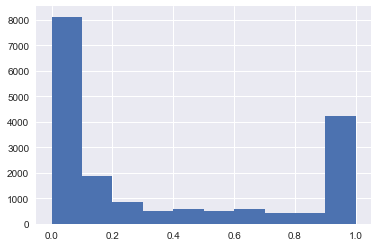

In [71]:
#normalize price
maxp = train_file.price.max()
#hist = train_file.price.hist(bins=10)
valuethred = 600.
train_file['price'] = train_file['price'].clip(lower=0.,upper=valuethred).div(valuethred,fill_value=None)
#train_file['price'] = train_file['price'].div(valuethred,fill_value=None)
hist = train_file['price'].hist(bins=10)
maxp


In [72]:
#clean up type 
#temp = train_file.type.drop_duplicates(keep='first',inplace=False)
#temp
mapping_type = {'international':1.,'local':2., 'NAN':0.}
train_file['type'] = train_file['type'].map(mapping_type)
train_file.head(10)

,name,lvl1,lvl2,lvl3,descrption,price,type
id,,,,,,,
1,Cuba Heartbreaker Eau De Parfum Spray 100ml/3.3oz,1.0,1.0,hand foot care,Formulated with oil-free hydrating botanicals/...,0.213333,1.0
2,32GB USB 3.0 Swivel Flash Drive Memory Stick S...,2.0,2.0,flash drives,<ul> <li>Interface: USB 3.0</li> <li>Capacity:...,0.024483,1.0
3,Eican ALP8L-01 Metal + PC Phone Cover Luxury A...,3.0,3.0,phone cases,<ul> <li>Aluminum Frame</li> <li>Built-in Stan...,0.023500,1.0
4,IPAKY Hybrid Luxury Silicone Case Cover And Pl...,3.0,3.0,phone cases,<ul> <li>Ultal thin Slim Style + Full Protecti...,0.029900,1.0
5,Phone case for iPhone 5/5s/SE You Can Be Sore ...,3.0,3.0,phone cases,<ul> <li>High Quality phone Case for iPhone 5/...,0.011333,1.0
6,NG-40C Ring-Shaped 40W 3166lm 5400K Macro Phot...,4.0,3.0,lighting studio equipment,<ul> <li>1. Color Temperature: 5400K</li> <li>...,0.648317,1.0
7,Asus TP300LJ-DW004H Transformer Book Flip 4GB ...,2.0,4.0,traditional laptops,"<div class=""prod_content""> <div class=""prod_de...",1.000000,2.0
8,High Quality Genuine Leather Belts For Men Rev...,5.0,5.0,accessories,"<ul> <li>Rotated buckle,A belt can have two co...",0.036233,1.0
9,McDonald's Coke Can Glass Limited Edition 12oz...,6.0,6.0,tableware,<ul> <li>Genuine issued McDonald's Coca Cola m...,0.041667,2.0
